In [1]:
import warnings
import pandas as pd
import numpy as np
import pandas as pd
from pandas.errors import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
import seaborn as sns
import matplotlib.pyplot as plt
from pybnesian import MutualInformation
import datetime
import plotly
from plotly.subplots import make_subplots
import os
import pickle
warnings.simplefilter(action='ignore', category=FutureWarning)
from scipy.stats import entropy, differential_entropy
from fsfc.generic.SPEC import NormalizedCut
from sklearn.preprocessing import StandardScaler

### Preprocessing

In [2]:
%run -i 'preprocessing.py'

# FSFC - NormalizedCut

In [3]:
try:
    with open('norm_cut', 'rb') as selects:
        selections = pickle.load(selects)
except FileNotFoundError as e:
    selections = dict()
    with open('norm_cut', 'wb') as selects:
        pickle.dump(selections, selects)


In [ ]:
selections

In [5]:
# start_day = '2021-10-01 00:00:00'
# end_day = '2023-04-09 23:58:00'

# start_day = pd.to_datetime(start_day, format='%Y-%m-%d %H:%M:%S')
# end_day = pd.to_datetime(end_day, format='%Y-%m-%d %H:%M:%S')
# scaler = StandardScaler()
# data = dfCV1[dfCV1.index.to_series().between(start_day, end_day)]
# data_scaled = data.copy()
# data_scaled[data_scaled.columns] = scaler.fit_transform(data_scaled)
# for delta in range((end_day - start_day).days + 1):
#     index_date = start_day + datetime.timedelta(days=delta)
#     index_date_offset = index_date  + datetime.timedelta(hours=23, minutes=58)
#     data_slice = data_scaled[data_scaled.index.to_series().between(index_date, index_date_offset)]

#     selections[index_date] = dict()
#     # Selection subset size range up to top 10
#     for k in range(37, 10, -1):
#         selector = NormalizedCut(k)
#         selector.fit(data_slice.to_numpy())
#         selections[index_date][k] = [translation_dict[x] for x in data.columns[selector.get_support()]]

#     with open('norm_cut', 'wb') as selects:
#         pickle.dump(selections, selects)





Text(0.5, 1.0, 'Number of times feature was selected')

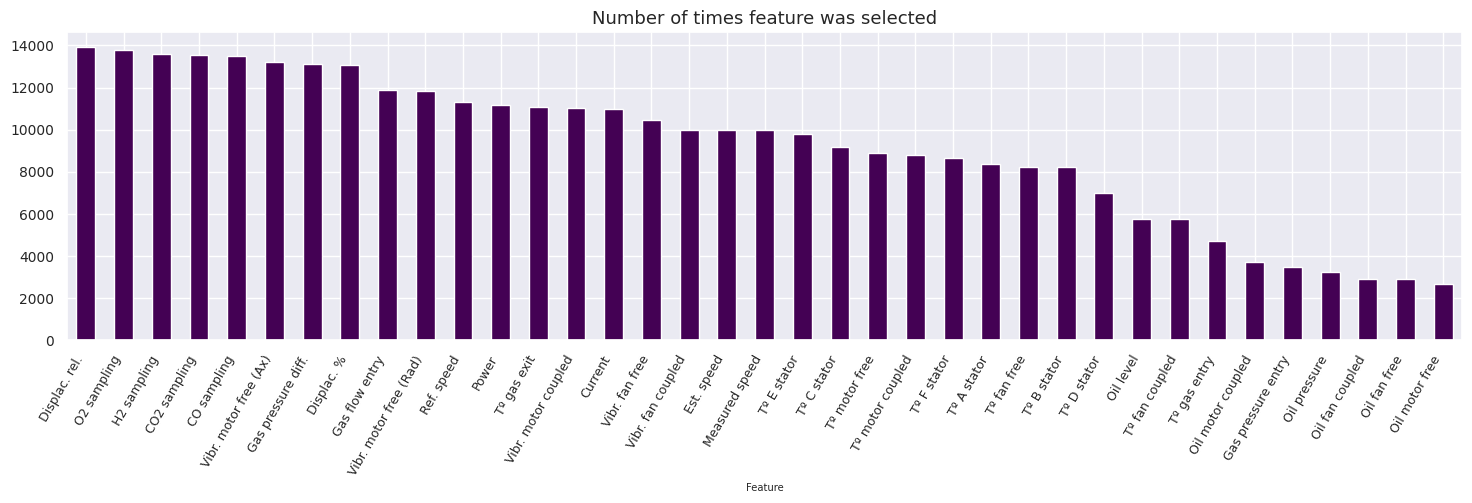

In [6]:
start_day = '2021-10-01 00:00:00'
end_day = '2023-04-09 00:00:00'

start_day = pd.to_datetime(start_day, format='%Y-%m-%d %H:%M:%S')
end_day = pd.to_datetime(end_day, format='%Y-%m-%d %H:%M:%S')
score_list = list()
for delta in range((end_day - start_day).days + 1):
    index_date = start_day + datetime.timedelta(days=delta)
    # Subset sizes
    kmax = 36
    kmin = 10
    for k in range(kmax, kmin, -1):
        score_list.extend(selections[index_date][k])


sns.set(color_codes=True, font_scale=0.6)
aux_df = pd.DataFrame(score_list, columns=['Feature'])
ax = aux_df.value_counts().plot.bar(cmap='viridis', x='Feature', title="Number of times feature was selected",figsize=(18,4),  fontsize=10, rot=60)
ax.set_xticklabels(labels=[x[0] for x in aux_df.value_counts().keys()], ha='right', fontsize=9)
plt.title("Number of times feature was selected", size=13)


In [7]:
custom_order = {
    'XXXXXXXXXX'
}

## Filter map - Pearson's corr

In [8]:
start_day = '2021-10-01 00:00:00'
end_day = '2023-04-09 23:58:00'
# start_day = '2022-01-21 00:00:00'
# end_day = '2022-02-20 23:58:00'
start_day = pd.to_datetime(start_day, format='%Y-%m-%d %H:%M:%S')
end_day = pd.to_datetime(end_day, format='%Y-%m-%d %H:%M:%S')
data = dfCV1[dfCV1.index.to_series().between(start_day, end_day)]
data = data[[x for x in custom_order.keys()]]
data.columns = [custom_order[x] for x in data.columns]

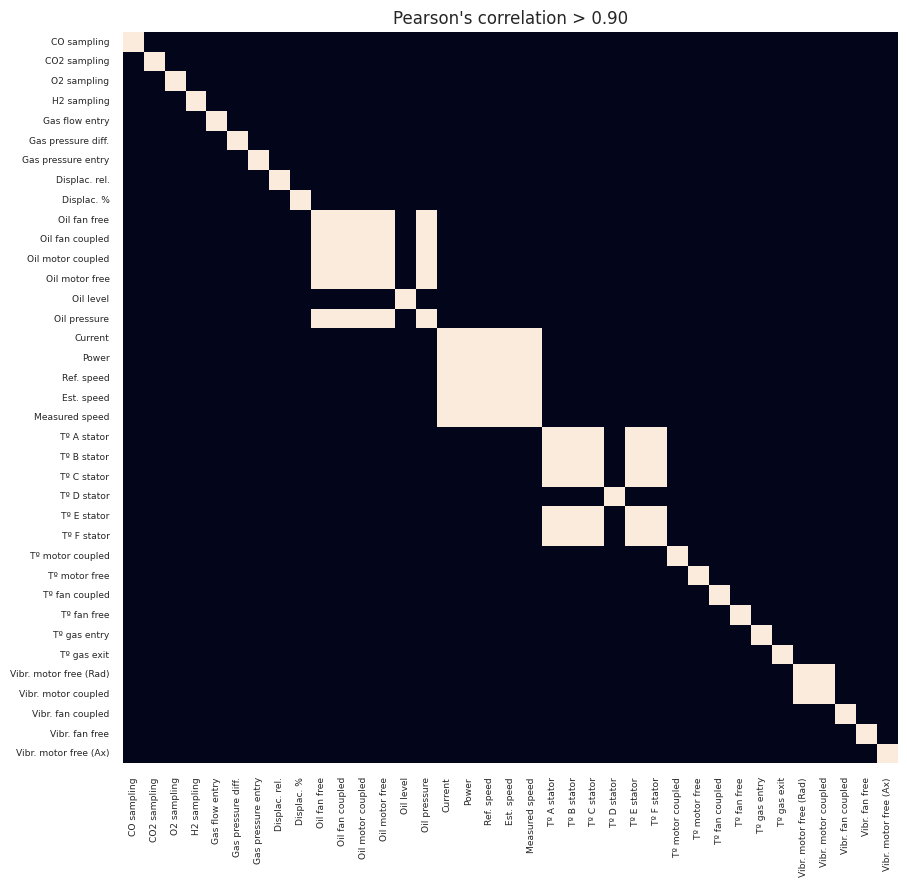

In [9]:
corr = data.corr()
corr[corr < 0.90] = -1
corr[corr > 0.90] = 1
plt.figure(figsize=(10, 9.5))
fig = sns.heatmap(corr, cbar=False)
# plt.xticks(rotation=50, ha='right')
plt.title('Pearson\'s correlation > 0.90', fontsize=12)
plt.savefig('pearson_corr.svg', format='svg', bbox_inches = 'tight')


In [10]:

kbest_pearson = [f"{corr.columns[i]} and {corr.columns[j]}" for i, j in zip(*np.where(corr.values > 0.9)) if i < j]

In [11]:
# Interesting > 0.9 corr
'Oil fan free and Oil fan coupled',
'Oil fan free and Oil motor coupled',
'Oil fan free and Oil motor free',
'Oil fan free and Oil pressure',
'Oil fan coupled and Oil motor coupled',
'Oil fan coupled and Oil motor free',
'Oil fan coupled and Oil pressure',
'Oil motor coupled and Oil motor free',
'Oil motor coupled and Oil pressure',
'Oil motor free and Oil pressure',
'Current and Power',
'Current and Ref. speed',
'Current and Est. speed',
'Current and Measured speed',
'Power and Ref. speed',
'Power and Est. speed',
'Power and Measured speed',
'Ref. speed and Est. speed',
'Ref. speed and Measured speed',
'Est. speed and Measured speed',
'Tº A stator and Tº B stator',
'Tº A stator and Tº C stator',
'Tº A stator and Tº E stator',
'Tº A stator and Tº F stator',
'Tº B stator and Tº C stator',
'Tº B stator and Tº E stator',
'Tº B stator and Tº F stator',
'Tº C stator and Tº E stator',
'Tº C stator and Tº F stator',
'Tº E stator and Tº F stator',
'Vibr. motor free (Rad) and Vibr. motor coupled'


# Intuition
print('Displac. rel. vs Displac. %\t\t', data[['Displac. rel.', 'Displac. %']].corr().iloc[0, 1])
print('Tº gas entry vs Tº gas exit\t\t', data[['Tº gas entry', 'Tº gas exit']].corr().iloc[0, 1])

Displac. rel. vs Displac. %		 0.2172256452581335
Tº gas entry vs Tº gas exit		 0.06793267422652942


## Filter map - NMI

In [12]:
mi = MutualInformation(data)
mi_matrix = corr.copy()
mi_matrix.loc[:, :]=1

In [13]:
data_cpy = data.copy()
mu, sigma = 0, 0.000001
# creating a noise with the same dimension as the dataset
noise = np.random.normal(mu, sigma, data_cpy.shape) 
data_cpy = data_cpy + noise

In [14]:
for i in mi_matrix.index:
    for j in mi_matrix.index:
        if i != j:
            mi_raw = mi.mi(i, j)
            ent1, ent2 = differential_entropy(data_cpy[i], method='vasicek'),  differential_entropy(data_cpy[j], method='vasicek')
            mi_matrix.loc[i, j] = mi_raw/max(ent1, ent2)

In [15]:
print(np.percentile(mi_matrix.to_numpy().flatten(), 93))

0.5198313512884797


NMI(X,Y) = I(X, Y)/max(H(X), H(Y))

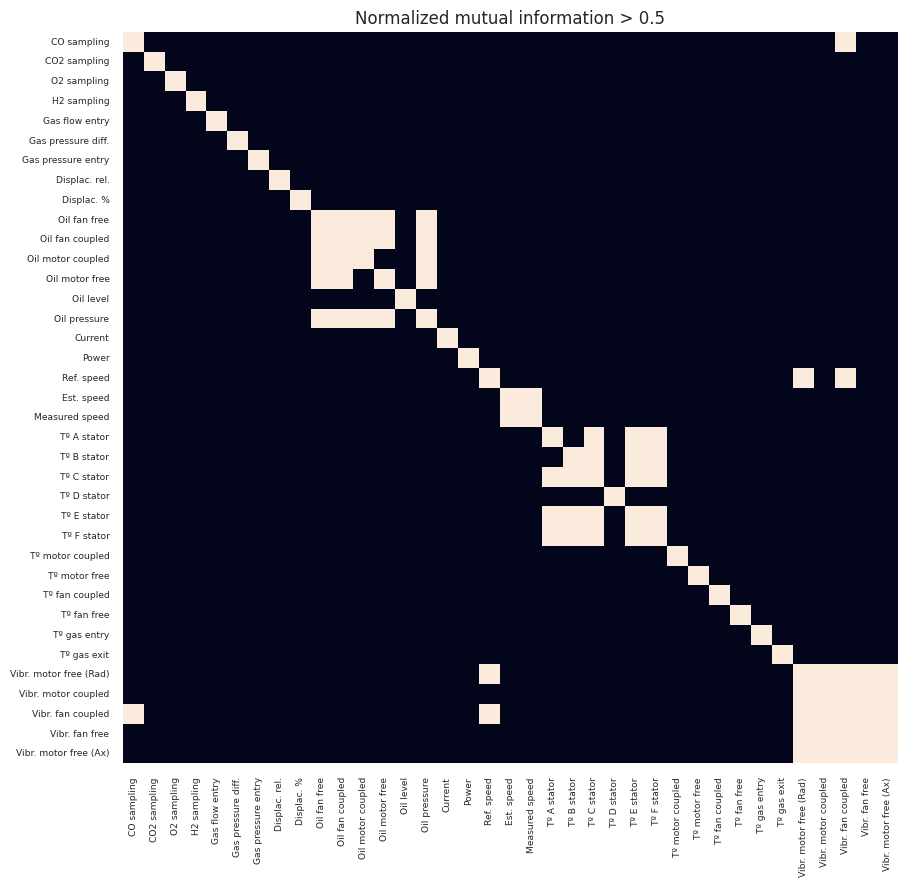

In [16]:
mi_theshold = 0.5
mi_matrix_trunc = mi_matrix.copy()
mi_matrix_trunc[mi_matrix_trunc < mi_theshold] = -1
mi_matrix_trunc[mi_matrix_trunc > mi_theshold] = 1
plt.figure(figsize=(10, 9.5))
sns.heatmap(mi_matrix_trunc, cbar=False)
plt.title(f'Normalized mutual information > {mi_theshold}', fontsize=12)
plt.savefig('NMI.svg', format='svg', bbox_inches = 'tight')


In [17]:
kbest_nmi = [f"{mi_matrix.columns[i]} and {mi_matrix.columns[j]}" for i, j in zip(*np.where(mi_matrix.values > 0.5)) if i < j]

In [18]:
'CO sampling and Current',
'CO sampling and Power',
'Displac. % and Oil motor coupled',
'Oil fan free and Oil fan coupled',
'Oil fan free and Oil pressure',
'Oil fan coupled and Oil pressure',
'Oil motor coupled and Vibr. fan free',
'Oil motor coupled and Vibr. motor free (Ax)',
'Oil motor free and Current',
'Est. speed and Measured speed',
'Tº A stator and Tº C stator',
'Tº A stator and Tº E stator',
'Tº A stator and Tº F stator',
'Tº B stator and Tº C stator',
'Tº B stator and Tº E stator',
'Tº B stator and Tº F stator',
'Tº C stator and Tº E stator',
'Tº C stator and Tº F stator',
'Tº E stator and Tº F stator',
'Vibr. motor free (Rad) and Vibr. motor coupled',
'Vibr. motor free (Rad) and Vibr. fan coupled',
'Vibr. motor free (Rad) and Vibr. fan free',
'Vibr. motor free (Rad) and Vibr. motor free (Ax)',
'Vibr. motor coupled and Vibr. fan coupled',
'Vibr. motor coupled and Vibr. fan free',
'Vibr. motor coupled and Vibr. motor free (Ax)',
'Vibr. fan coupled and Vibr. fan free',
'Vibr. fan coupled and Vibr. motor free (Ax)',
'Vibr. fan free and Vibr. motor free (Ax)'

'Vibr. fan free and Vibr. motor free (Ax)'

#### kbest_pearson intersection kbest_nmi

In [19]:
[x for x in kbest_pearson if (x in kbest_nmi)]

['Oil fan free and Oil fan coupled',
 'Oil fan free and Oil motor coupled',
 'Oil fan free and Oil motor free',
 'Oil fan free and Oil pressure',
 'Oil fan coupled and Oil motor coupled',
 'Oil fan coupled and Oil motor free',
 'Oil fan coupled and Oil pressure',
 'Oil motor coupled and Oil pressure',
 'Oil motor free and Oil pressure',
 'Est. speed and Measured speed',
 'Tº A stator and Tº C stator',
 'Tº A stator and Tº E stator',
 'Tº A stator and Tº F stator',
 'Tº B stator and Tº C stator',
 'Tº B stator and Tº E stator',
 'Tº B stator and Tº F stator',
 'Tº C stator and Tº E stator',
 'Tº C stator and Tº F stator',
 'Tº E stator and Tº F stator',
 'Vibr. motor free (Rad) and Vibr. motor coupled']